In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np
import pandas as pd
import os
import json
import glob
import sys
import spacy
import gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk; nltk.download('stopwords')
import seaborn as sns
import operator
import pickle
from nltk.corpus import stopwords
# Any results you write to the current directory are saved as output.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nlp/osabo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Preprocess Data**

In [26]:
# sys.path.insert(0, "../")

root_path = '/home/nlp/data/covid19papers/'


corona_features = {"doc_id": [None], "source": [None], "title": [None],
                  "abstract": [None], "text_body": [None]}
corona_df = pd.DataFrame.from_dict(corona_features)

json_filenames = glob.glob(f'{root_path}/**/*.json', recursive=True)

In [27]:
def return_corona_df(json_filenames, df, source):

    for file_name in json_filenames:

        row = {"doc_id": None, "source": None, "title": None,
              "abstract": None, "text_body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            doc_id = data['paper_id']
            row['doc_id'] = doc_id
            row['title'] = data['metadata']['title']

            # Now need all of abstract. Put it all in 
            # a list then use str.join() to split it
            # into paragraphs. 

            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = "\n ".join(abstract_list)

            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n ".join(body_list)
            
            row['text_body'] = body
            
            # Now just add to the dataframe. 
            
            if source == 'b':
                row['source'] = "BIORXIV"
            elif source == "c":
                row['source'] = "COMMON_USE_SUB"
            elif source == "n":
                row['source'] = "NON_COMMON_USE"
            elif source == "p":
                row['source'] = "PMC_CUSTOM_LICENSE"
            
            df = df.append(row, ignore_index=True)
    
    return df
    
corona_df = return_corona_df(json_filenames, corona_df, 'b')

In [28]:
# stop words
stop_words = stopwords.words("english")
stop_words.extend(['et', 'al'])

In [29]:
def sent_to_words(sentence):
    """
    divides sentence into words and removes punctuations
    """
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(doc):
    """
    removes stopwords
    """
    return [word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words]

def get_bigrams(text, bigram_model):
    """
    get bigrams
    """
    return bigram_model[text]

def preprocess_text(text, bigram_model):
    data_words = list(sent_to_words(text))
    data_words = remove_stopwords(data_words)
    data_words = get_bigrams(data_words, bigram_model)
    return data_words

In [30]:
bigram_model = gensim.models.phrases.Phrases(corona_df['text_body'].to_string(), min_count=1, threshold=2)
# clean text
corona_df['preprocessed_text'] = corona_df['text_body'].apply(preprocess_text, args=(bigram_model,))
corona_df.to_csv('corona_preprocessed.csv', index = False, header=True)

In [31]:
# load preprocessed csv
#corona_df = pd.read_csv('corona_preprocessed.csv')

**Word2Vec on Corona Dataset**

In [32]:
# train Word2Vec model
model = gensim.models.Word2Vec(corona_df['preprocessed_text'], size=100, window=5, 
                 min_count=1, workers=4)
model.save("corona_word2vec.model")

In [33]:
model = gensim.models.Word2Vec.load("corona_word2vec.model")

/home/nlp/osabo/anaconda3/envs/jupyther/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':
/home/nlp/osabo/anaconda3/envs/jupyther/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB o

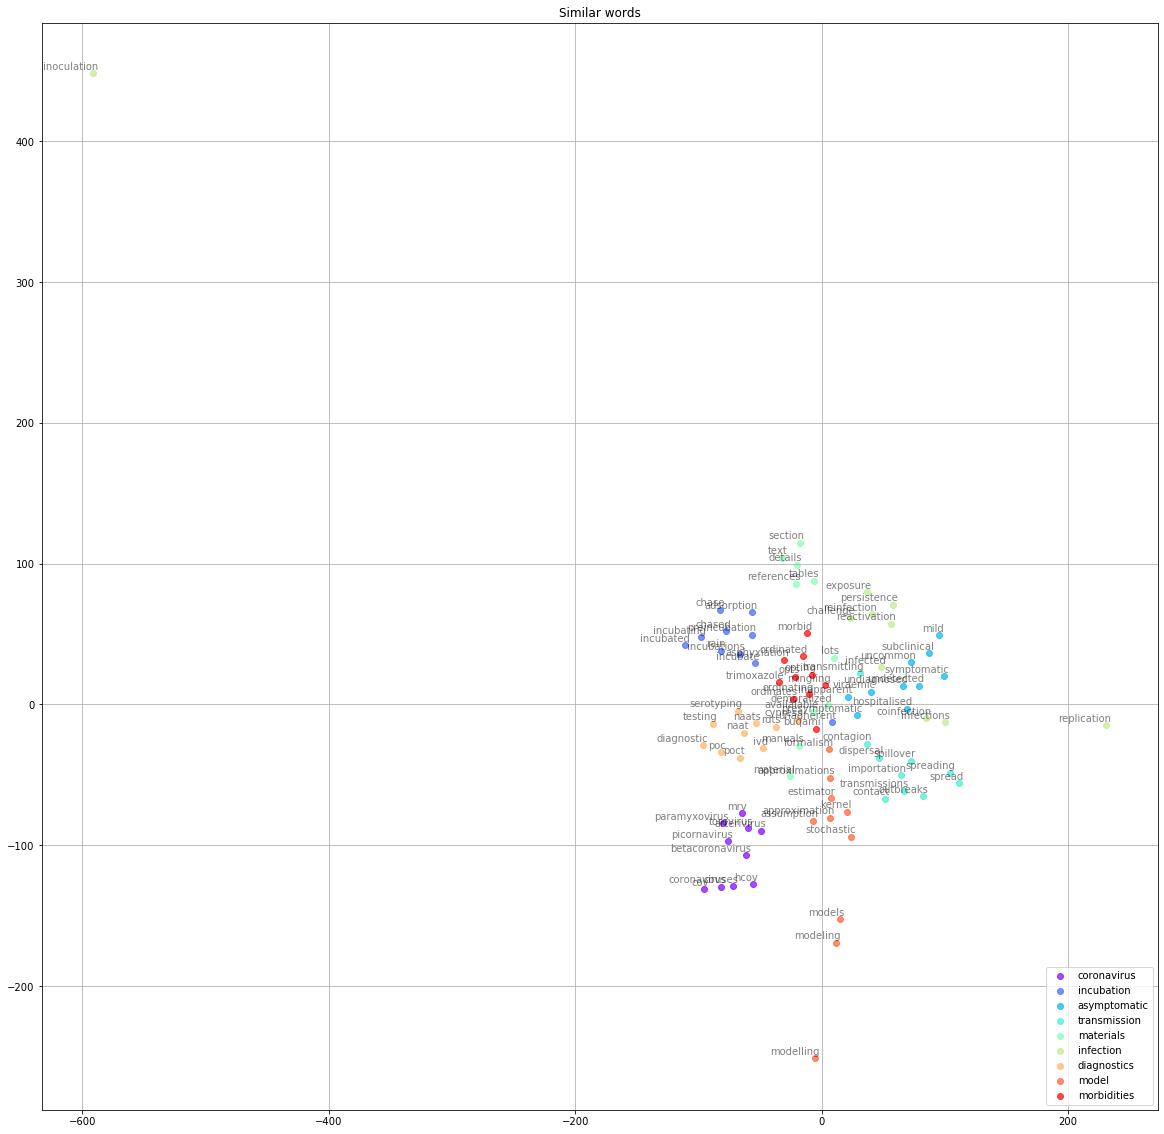

In [34]:
# Visulaize Word Embeddings
from sklearn.manifold import TSNE

keys = ['coronavirus', 'incubation', 'asymptomatic', 'transmission', 'materials',
       'infection', 'diagnostics', 'model', 'morbidities']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)



embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(20, 20))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

**LDA - Topic Modeling**

In [35]:
# create index to word dictionary
id2word = gensim.corpora.Dictionary(corona_df['preprocessed_text'])

# create indexed text
corpus = [id2word.doc2bow(text) for text in corona_df['preprocessed_text']]

In [36]:
n_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=555)

In [37]:
corona_df['lda_label'] =[max(lda_model[c], key=operator.itemgetter(1))[0] for c in corpus]

In [38]:
pickle.dump(lda_model, open('lda_model.pk', 'wb'))
lda_model = pickle.load(open('lda_model.pk', 'rb'))

In [39]:
def get_topics(model, topic_range, topn):
    word_dict = {};
    for i in topic_range:
        words = model.show_topic(i, topn);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

n_words = 10
get_topics(lda_model, range(0,n_topics), n_words)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,cells,health,using,virus,cells,patients,rna,data,virus,cells
1,mice,disease,used,using,cell,study,protein,model,vaccine,protein
2,cell,data,detection,sequences,infection,respiratory,di,number,cells,proteins
3,zikv,public,dna,samples,cd,infection,virus,time,infection,cell
4,brain,cases,pcr,viruses,mice,clinical,viral,used,using,fig
5,cd,also,assay,gene,virus,disease,viruses,models,vaccines,activity
6,fig,sars,based,sequence,il,patient,proteins,transmission,viral,viral
7,il,may,samples,genes,ifn,children,binding,population,antibody,using
8,also,study,figure,cov,expression,group,sequence,rate,mice,expression
9,figure,risk,results,genome,viral,may,cells,epidemic,used,figure


In [40]:
# human topic annotation
lda_dictionary = {0: 'experiments', 1: 'cells', 2: 'prep_latin', 3 : 'protein', 4: 'model', 
                  5: 'treatment', 6:'genetics', 7:'infection', 8:'risks', 9:'symptoms'}

def transform(num):
    return lda_dictionary[num]

corona_df['lda_label_string'] = corona_df['lda_label'].apply(transform)

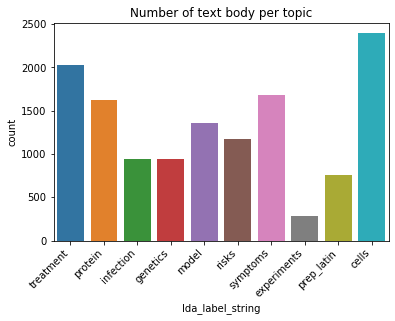

In [41]:
ax = sns.countplot(x="lda_label_string",data=corona_df)
ax.set_title('Number of text body per topic');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');